In [1]:
import sys
sys.path.insert(0, "/kaggle/input/magnatagatune-pcm8-top50")
from magna_loader import MagnaLoader

In [2]:
mloader = MagnaLoader('/kaggle/input/magnatagatune-pcm8-top50/magnatagatune_pcm8_top50.bin')
mloader.samples_count

21108

In [3]:
import tensorflow as tf
import numpy as np
import gc

In [4]:
y_classes = 10
train_test_ratio = 0.9
test_x, test_y = [], []

def prepare_sample(x,y):
    x = x.reshape((-1, 1)) / 128
    y = y[:y_classes].astype(np.float32)
    return x,y

x_usage = np.zeros(mloader.samples_count)
for i, (x,y) in enumerate(mloader.iterate(prepare_sample)):
    if sum(y)==0: continue
    if i<train_test_ratio*mloader.samples_count:
        x_usage[i] = 1
    else:
        x_usage[i] = 2
        test_x.append(x)
        test_y.append(y)
        
test_x = np.array(test_x)
test_y = np.array(test_y)
gc.collect()

train_count = sum(x_usage==1)
print("Train count =", train_count)

def magna_generator():        
    while True:
        for i, (x,y) in enumerate(mloader.iterate(prepare_sample)):
            if x_usage[i]==1:
                yield x,y        

Train count = 14837


In [5]:
# run until test data is created
for x,y in magna_generator():
    if test_x is not None: break

In [6]:
test_x.shape, test_y.shape

((1635, 465984, 1), (1635, 10))

In [7]:
x_shape = (465984, 1)
y_shape = (y_classes,)

In [8]:
magna_dataset = tf.data.Dataset.from_generator(magna_generator, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=(x_shape, y_shape))
batch_size = 16
magna_dataset = magna_dataset.shuffle(150).batch(batch_size)

In [9]:
def create_cnn1d_model():
    conv_cfg = {'kernel_size':(3,), 'padding':'same', 'activation':'leaky_relu'}
    x = x0 = tf.keras.layers.Input(x_shape)
    x = tf.keras.layers.Conv1D(32, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(64, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(128, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(128, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Conv1D(256, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(256, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(512, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(512, **conv_cfg)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(1024, **conv_cfg)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(1024, **conv_cfg)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(100, activation='leaky_relu')(x)    
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(y_shape[-1], activation='sigmoid')(x)

    return tf.keras.models.Model(x0, x)

model = create_cnn1d_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 465984, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 465984, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 155328, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 155328, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 155328, 64)          │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 51776, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 51776, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 51776, 128)          │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 17258, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 17258, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 17258, 128)          │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 5752, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 5752, 256)           │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 1917, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1917, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 1917, 256)           │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 639, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 639, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 639, 512)            │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 213, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 213, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,643,606 (32.97 MB)

 Trainable params: 8,638,486 (32.95 MB)

 Non-trainable params: 5,120 (20.00 KB)

In [10]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [11]:
history = model.fit(magna_dataset, 
                   epochs=10,
                   steps_per_epoch=train_count//batch_size,
                   validation_data=(test_x, test_y))

Epoch 1/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 189s 180ms/step - binary_accuracy: 0.7600 - loss: 0.7564 - val_binary_accuracy: 0.7173 - val_loss: 2.1204
Epoch 2/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 154s 166ms/step - binary_accuracy: 0.8028 - loss: 0.4617 - val_binary_accuracy: 0.5536 - val_loss: 1.2375
Epoch 3/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 153s 165ms/step - binary_accuracy: 0.8137 - loss: 0.4318 - val_binary_accuracy: 0.6436 - val_loss: 1.1126
Epoch 4/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 153s 165ms/step - binary_accuracy: 0.8216 - loss: 0.4058 - val_binary_accuracy: 0.8385 - val_loss: 0.3513
Epoch 5/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 152s 165ms/step - binary_accuracy: 0.8286 - loss: 0.3834 - val_binary_accuracy: 0.8213 - val_loss: 0.3685
Epoch 6/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 152s 165ms/step - binary_accuracy: 0.8338 - loss: 0.3719 - val_binary_accuracy: 0.8368 - val_loss: 0.3731
Epoch 7/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 152s 165ms/step - binary_accuracy: 0.8372 - loss: 0.3643 - val_binary_accuracy: 0.83

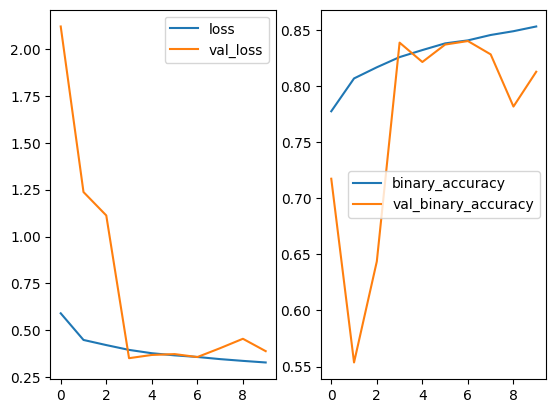

In [12]:
from matplotlib import pyplot as plt
fix, ax = plt.subplots(1,2)

ax[0].plot(history.history['loss'], label='loss')
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].legend()

ax[1].plot(history.history['binary_accuracy'], label='binary_accuracy')
ax[1].plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
ax[1].legend()
plt.show()

In [13]:
del magna_dataset
gc.collect()

2820

In [14]:
from sklearn.metrics import roc_curve

In [15]:
y_pred = model.predict(test_x)

52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step


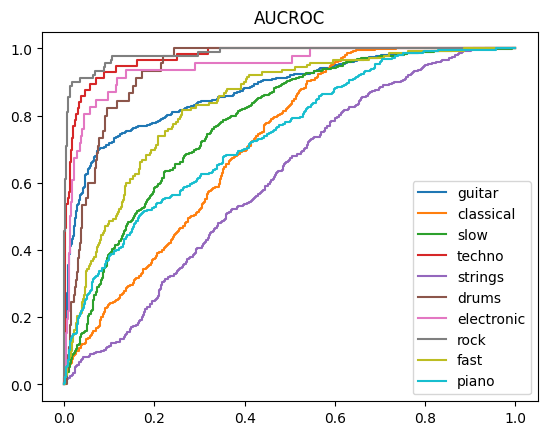

In [16]:
classes=["guitar", "classical", "slow", "techno", "strings", "drums", 
         "electronic", "rock", "fast", "piano"]
F = [None]*y_classes
T = [None]*y_classes
for i in range(y_classes):
    F[i], T[i], ths = roc_curve(test_y[:,i], y_pred[:,i], pos_label=1)
    plt.plot(F[i], T[i], label=classes[i])
plt.legend()
plt.title("AUCROC")
plt.show()

In [17]:
def auc(x,y):
    s = 0
    for i in range(1, len(x)):
        s += (y[i]+y[i-1])*abs((x[i]-x[i-1]))/2
    return s
for g, a in [(classes[i], auc(F[i], T[i])) for i in range(y_classes)]:
    print(g,a)

guitar 0.876486947188027
classical 0.7161460010735375
slow 0.7830892028907347
techno 0.9732877951687324
strings 0.6101819276078954
drums 0.9352480782669461
electronic 0.9458915916491093
rock 0.9844660194174757
fast 0.8349150495740687
piano 0.7394276094276097


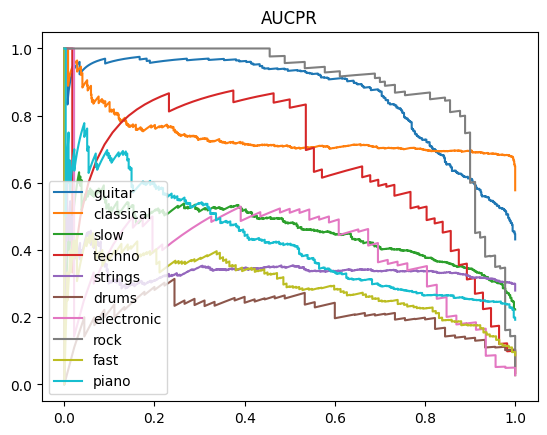

In [18]:
from sklearn.metrics import precision_recall_curve
P = [None]*y_classes
R = [None]*y_classes
for i in range(y_classes):
    P[i], R[i], ths = precision_recall_curve(test_y[:,i], y_pred[:,i], pos_label=1)
    plt.plot(R[i], P[i], label=classes[i])
plt.legend()
plt.title("AUCPR")
plt.show()

In [19]:
for g, a in [(classes[i], auc(R[i], P[i])) for i in range(y_classes)]:
    print(g,a)

guitar 0.8617374826715047
classical 0.7359964147026683
slow 0.4545080477026551
techno 0.6545424825238756
strings 0.33962228987264953
drums 0.20976455151813392
electronic 0.3993784518647155
rock 0.8918681464607146
fast 0.2962778375048437
piano 0.42753819599181847


In [20]:
from sklearn.metrics import confusion_matrix

for i in range(y_classes):
    print(classes[i])    
    cmat = confusion_matrix(test_y[:,i], y_pred[:,i]>=0.5)    
    print(cmat)
    p = cmat[0,0]/(cmat[0,0]+cmat[1,0])
    r = cmat[0,0]/(cmat[0,0]+cmat[0,1])
    print("Accuracy =", (cmat[0,0]+cmat[1,1])/(cmat[0,0]+cmat[0,1]+cmat[1,0]+cmat[1,1]))
    print("Prec =", p)
    print("Recall =", r)    
    print("F1 = ", 2*p*r/(p+r))

guitar
[[695 234]
 [133 573]]
Accuracy = 0.7755351681957187
Prec = 0.8393719806763285
Recall = 0.7481162540365985
F1 =  0.7911212293682415
classical
[[676  14]
 [867  78]]
Accuracy = 0.46116207951070337
Prec = 0.43810758263123784
Recall = 0.9797101449275363
F1 =  0.6054635020152263
slow
[[640 630]
 [ 35 330]]
Accuracy = 0.5932721712538226
Prec = 0.9481481481481482
Recall = 0.5039370078740157
F1 =  0.6580976863753213
techno
[[1544   35]
 [  13   43]]
Accuracy = 0.9706422018348624
Prec = 0.9916506101477199
Recall = 0.9778340721975934
F1 =  0.9846938775510204
strings
[[1176    2]
 [ 456    1]]
Accuracy = 0.7198776758409786
Prec = 0.7205882352941176
Recall = 0.99830220713073
F1 =  0.8370106761565836
drums
[[1566   24]
 [  34   11]]
Accuracy = 0.964525993883792
Prec = 0.97875
Recall = 0.9849056603773585
F1 =  0.9818181818181818
electronic
[[1566   23]
 [  21   25]]
Accuracy = 0.9730886850152906
Prec = 0.9867674858223062
Recall = 0.9855254877281309
F1 =  0.9861460957178841
rock
[[1536    9]
